# CNN을 통한 Fashion-MNIST 데이터 이미지 분류

--실행 환경 : Python 3.10.13--


# 필요한 라이브러리 설치 및 환경 구축

Fashion-MNIST 데이터셋을 불러옵니다.  
load_fashion_mnist 함수 호출하여 data_train, data_test, train_loader, test_loader가 생성되어 접근이 가능합니다.


In [1]:
#필요한 라이브러리 설치 및 환경 구축
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv

from pytorchcv import load_fashion_mnist, train, plot_results, plot_convolution, display_dataset

load_fashion_mnist(batch_size=128)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data exploration
Fashion_mnist 데이터셋에 대한 탐색 및 확인 작업입니다.

불러온 fashion-mnist의 train, test 데이터셋의 크기를 확인합니다.

간단하게 데이터셋의 startIndex부터 30개의 이미지 뽑아 출력을 통해 확인합니다.

Size of tranning data: 60000
Size of test data: 10000


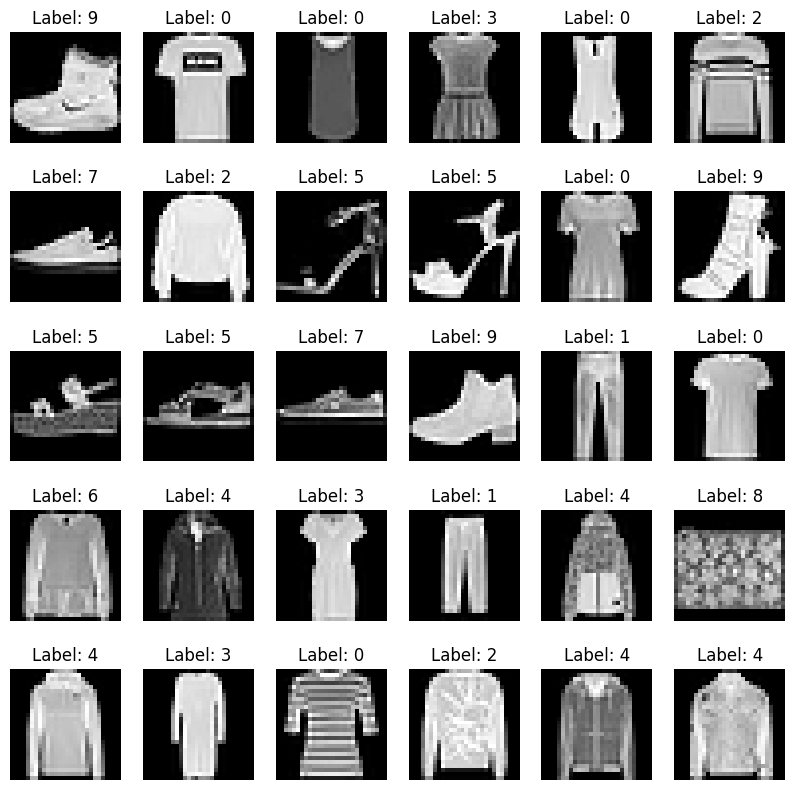

In [2]:
import matplotlib.pyplot as plt

# train_data의 데이터셋 크기
train_data_size = len(train_loader.dataset)
print("Size of tranning data:", train_data_size)

# test_data의 데이터셋의 크기
test_data_size = len(test_loader.dataset)
print("Size of test data:", test_data_size)

# 샘플 이미지과 레이블을 첫 번째 배치로 지정
sample_image, sample_label = next(iter(train_loader))

# 30개의 샘플 이미지와 레이블 출력
plt.figure(figsize=(10, 10)) #이미지 크기 설정
for i in range(30):
    plt.subplot(5, 6, i + 1)
    plt.title(f'Label: {sample_label[i]}') #레이블 명을 이미지 위에서 출력
    plt.axis('off') # 눈금과 축 삭제
    plt.imshow(sample_image[i].squeeze(), cmap='gray') # Grayscale 이미지로 변환 및 표시

plt.show()

# Temporary filter and convolution operations

컨볼루션 연산을 시각화하는 함수 plot_convolution을 통해 임시적으로 커널 값을 선정하여 수직 edge, 수평 edge 특징과 패턴을 추출 여부를 확인하고 이미지를 출력해봅니다.

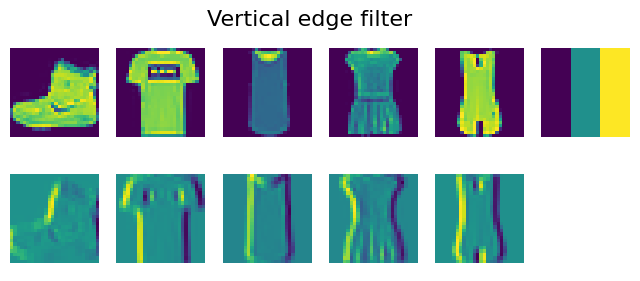

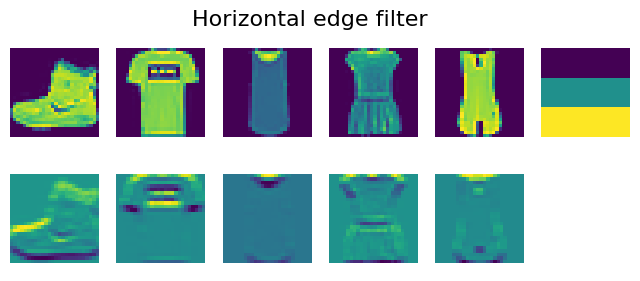

In [3]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

# CNN 모델 구축 (1개의 컨볼루션 레이어, 풀링 레이어 포함)

PyTorch를 사용하여 간단한 신경망 모델을 정의하고, 구조를 요약해 출력하는 과정입니다.

정의한 CNN 모델을 통해 훈련 데이터셋을 이미지 패턴 및 특징 분석을 진행합니다.

Grayscale 이미지의 입력 채널 1개와 디폴트 값 출력 채널 9개이고 커널 사이즈가 5 * 5인 컨볼루션 레이어를 정의하고, 다차원 입력을 평탄화 하는 flatten 레이어와 5184(컨볼루션한 레이어의 형태에서 가져온 9 * 24 * 24)개의 입력 특성을 10개의 출력 특성(분류)으로 변환하는 완전 연결 레이어를 정의하여 모델 생성을 정의하는 코드입니다.

끝에선 이렇게 정의된 모델을 생성하고 생성된 모델의 요약 정보를 출력합니다.

Total params의 개수인 52,084의 양이 변경할 수 있는 파라미터(wait)의 총 개수입니다.

In [4]:
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


# CNN 모델 장치 전달과 최적화 함수 구현

앞서 정의한 CNN 모델을 통해 학습을 진행하는 함수를 구현합니다.

train 함수는 (모델, train_data, test_data, 학습 횟수)을 매개변수로 받아 앞서 정의한 CNN모델을 장치 이동, Adam 최적화 도구를 통한 최적화 작업을 진행하고 history에 학습 중간마다 정확도와 손실을 저장합니다. 이후에는 학습이 완료되면 손실과 정확도를 기록한 history 딕셔너리를 반환을 반환하는 과정을 가지고 있습니다.


In [5]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs): #제시된 훈련 횟수만큼 반복
            model.train() #모델 훈련 모드 전환
            train_loss, train_correct, train_total = 0, 0, 0 #훈련 손실, 훈련 정확도, 총 훈련 개수 초기화 
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            #모델 검증 모드 전환
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



# 훈련 데이터를 CNN 모델을 통해 학습 및 결과 출력

train함수를 통해 12번의 학습 과정을 진행하고 리턴된 history 값을 통해 학습 결과를 시각화 하는 plot_results 함수로 그래프를 제작합니다.

Epoch 1/12: Train Loss: 0.0041, Train Acc: 81.58%, Test Loss: 0.0034, Test Acc: 84.55%
Epoch 2/12: Train Loss: 0.0029, Train Acc: 86.83%, Test Loss: 0.0031, Test Acc: 85.70%
Epoch 3/12: Train Loss: 0.0026, Train Acc: 88.20%, Test Loss: 0.0030, Test Acc: 86.51%
Epoch 4/12: Train Loss: 0.0024, Train Acc: 88.97%, Test Loss: 0.0028, Test Acc: 86.98%
Epoch 5/12: Train Loss: 0.0023, Train Acc: 89.57%, Test Loss: 0.0027, Test Acc: 87.43%
Epoch 6/12: Train Loss: 0.0022, Train Acc: 90.06%, Test Loss: 0.0027, Test Acc: 87.58%
Epoch 7/12: Train Loss: 0.0021, Train Acc: 90.49%, Test Loss: 0.0027, Test Acc: 87.73%
Epoch 8/12: Train Loss: 0.0020, Train Acc: 90.94%, Test Loss: 0.0026, Test Acc: 88.07%
Epoch 9/12: Train Loss: 0.0019, Train Acc: 91.27%, Test Loss: 0.0026, Test Acc: 88.33%
Epoch 10/12: Train Loss: 0.0018, Train Acc: 91.55%, Test Loss: 0.0026, Test Acc: 88.52%
Epoch 11/12: Train Loss: 0.0018, Train Acc: 91.91%, Test Loss: 0.0025, Test Acc: 88.76%
Epoch 12/12: Train Loss: 0.0017, Train Ac

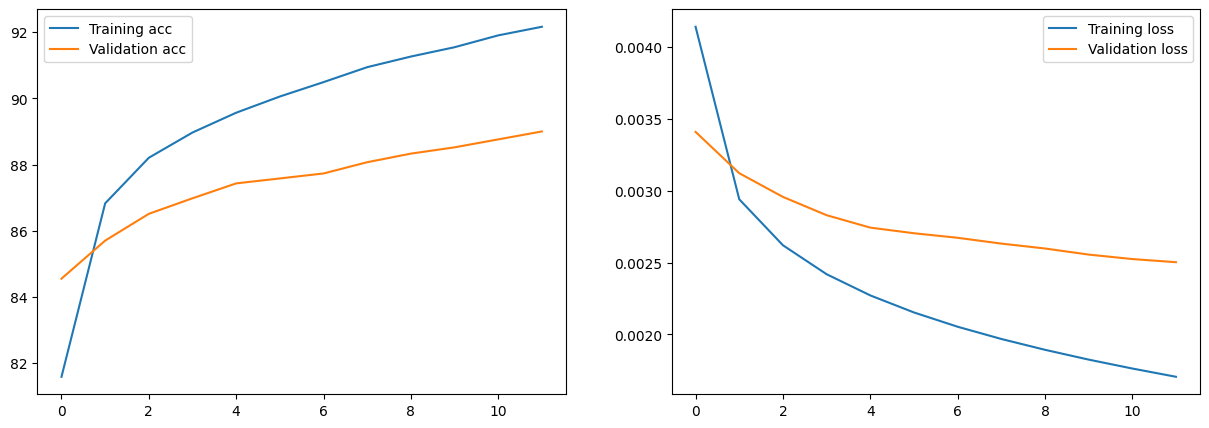

In [6]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net,train_loader,test_loader,epochs=12)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

해당 그래프를 통해 Trainning 데이터 셋에 대한 훈련 정확도와 훈련 손실도의 변화를 알 수 있으며, Test 데이터셋에 대한 검증의 정확도와 손실을 확인할 수 있습니다.

# 학습 결과에 대한 분석
 1. Train_Data에 대한 학습에서는 10번의 학습 이후에도 꾸준히 훈련 정확도가 높아지고 손실도는 낮아지고 있음을 확인할 수 있습니다.
 2. Test_Data에 대한 검증에서는 6-7번의 중간 과정 학습부터 정확도 향샹률이 저하되기 시작했으며 손실도 또한 중간 과정부터 학습 이후에는 변동에 있어서 큰 차이가 없고 수렴하고 있음을 확인할 수 있습니다.
 3. 이로써 Test_Data에 대한 검증 정확도와 손실 추세를 보았을 때 거의 수렴하는 형태를 가지고 있으며 학습에 있어서 한계를 확인 할 수 있습니다.

In [12]:
from pytorchcv import validate

loss_val, acc_val = validate(net, test_loader)

print("4. 검증에 있어서의 최종 정확도는{:.2f}%를 가지고 ".format(acc_val*100), end="")
print("손실도는 {:.4f}을 가진다는 것을 확인 할 수 있습니다.".format(loss_val))

4. 검증에 있어서의 최종 정확도는89.00%를 가지고 손실도는 0.0025을 가진다는 것을 확인 할 수 있습니다.


# 분류에 있어 오류가 발생한 레이블 클래스 시각화

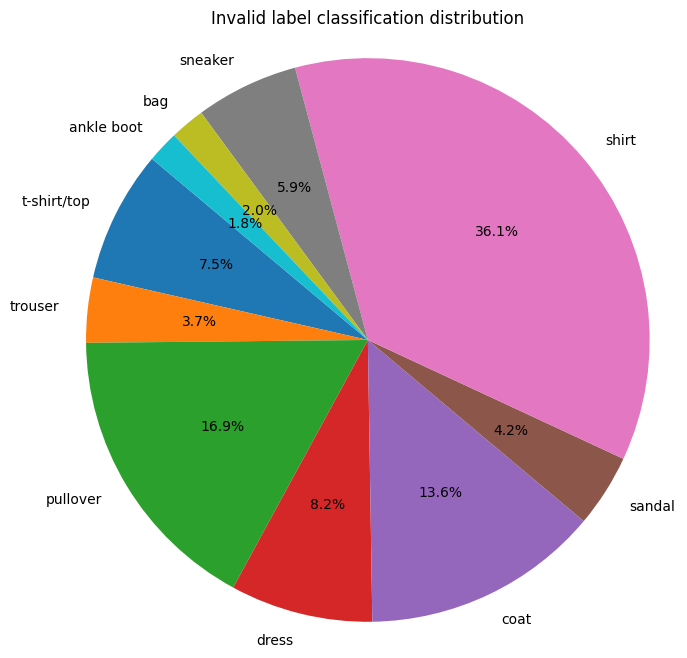

In [16]:
labels_map = { 0: "t-shirt/top", 1: "trouser", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}
# 공식 데이터에 따라 레이블의 특성명을 지정하고 딕셔너리에 저장

def Invalid_classification_plot(net, dataloader, labels_map): 
    default_device = "cpu"
    net.eval() # 신경망 모델을 평가 모드로 설정 
    errlabel_count = {label: 0 for label in labels_map.values()} # 분류 오류 발생 횟수 저장할 딕셔너리 초기화
    
    with torch.no_grad(): # 시각화에 있어서 불필요한 기울기 계산 제외
        for features, labels in dataloader: # 데이터 로더로부터 특징(feature)과 레이블(label)을 반복적으로 가져옴
            features = features.to(default_device) # 입력 데이터를 기본 디바이스로 전송
            labels = labels.to(default_device) # 레이블을 기본 계산 장치로 이동
            
            outputs = net(features) # 모델에 테스트 데이터를 전달하여 예측 수행
            _, predicted = torch.max(outputs, 1)
            
            err_idx = (predicted != labels).nonzero().squeeze() # 예측 레이블을 실제 레이블 값과 비교하여 분류 오류 인덱스 추출
            
            for idx in err_idx:
                true_label = labels[idx].item() # 분류 오류가 일어난 레이블 인덱스를 통한 실제 레이블 확인
                errlabel_count[labels_map[true_label]] += 1  # 잘못 분류된이미지의 횟수 계산
    
    labels = list(errlabel_count.keys())
    counts = list(errlabel_count.values())
    
    # 시각화
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal') # 원형 그래프를 원으로 보이도록 변형
    plt.title('Invalid label classification distribution')
    plt.show()


Invalid_classification_plot(net, test_loader, labels_map)